##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Anomaly detection with embeddings

<table align="left">
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/examples/Anomaly_detection_with_embeddings.ipynb"><img src="../images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Overview

This tutorial demonstrates how to use the embeddings from the Gemini API to detect potential outliers in your dataset. You will visualize a subset of the 20 Newsgroup dataset using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and detect outliers outside a particular radius of the central point of each categorical cluster.


In [ ]:
!pip install -U -q "google-generativeai>=0.7.2"

In [ ]:
import re
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import google.generativeai as genai

# Used to securely store your API key
from google.colab import userdata

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [ ]:
API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=API_KEY)

## Prepare dataset

The [20 Newsgroups Text Dataset](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html){:.external} contains 18,000 newsgroups posts on 20 topics divided into training and test sets. The split between the training and test datasets are based on messages posted before and after a specific date. This tutorial uses the training subset.

In [2]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Here is the first example in the training set.

In [3]:
idx = newsgroups_train.data[0].index('Lines')
print(newsgroups_train.data[0][idx:])

Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [4]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

# Cut off each text entry after 5,000 characters
newsgroups_train.data = [d[0:5000] if len(d) > 5000 else d for d in newsgroups_train.data]

In [5]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


Next, sample some of the data by taking 150 data points in the training dataset and choosing a few categories. This tutorial uses the science categories.

In [6]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

,index,Text,Label,Class Name
0,1650,Re: Off the shelf cheap DES keyseach machine\...,11,sci.crypt
1,1651,Re: Do we need the clipper for cheap security...,11,sci.crypt
2,1652,Re: Secret algorithm [Re: Clipper Chip and cr...,11,sci.crypt
3,1653,Re: Secret algorithm [Re: Clipper Chip and cr...,11,sci.crypt
4,1654,"Re: Screw the people, crypto is for hard-core...",11,sci.crypt
...,...,...,...,...
595,2245,"Re: Space Station Redesign, JSC Alternative #...",14,sci.space
596,2246,Re: Space Debris\nOrganization: NASA Langley ...,14,sci.space
597,2247,Re: Venus Lander for Venus Conditions.\nOrgan...,14,sci.space
598,2248,Re: Space Station radio commercial\nOrganizat...,14,sci.space


In [7]:
df_train['Class Name'].value_counts()

Class Name
sci.crypt          150
sci.electronics    150
sci.med            150
sci.space          150
Name: count, dtype: int64

## Create the embeddings

In this section, you will see how to generate embeddings for the different texts in the dataframe using the embeddings from the Gemini API.

### API changes to Embeddings with model embedding-001

For the new embeddings model, embedding-001, there is a new task type parameter and the optional title (only valid with task_type=`RETRIEVAL_DOCUMENT`).

These new parameters apply only to the newest embeddings models.The task types are:

Task Type | Description
---       | ---
RETRIEVAL_QUERY	| Specifies the given text is a query in a search/retrieval setting.
RETRIEVAL_DOCUMENT | Specifies the given text is a document in a search/retrieval setting.
SEMANTIC_SIMILARITY	| Specifies the given text will be used for Semantic Textual Similarity (STS).
CLASSIFICATION	| Specifies that the embeddings will be used for classification.
CLUSTERING	| Specifies that the embeddings will be used for clustering.

In [8]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    # Set the task_type to CLUSTERING.
    embedding = genai.embed_content(model=model,
                                    content=text,
                                    task_type="clustering")['embedding']
    return np.array(embedding)

  return embed_fn

def create_embeddings(df):
  model = 'models/embedding-001'
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(df_train)
df_train.drop('index', axis=1, inplace=True)

  0%|          | 0/600 [00:00<?, ?it/s]

## Dimensionality reduction

The dimension of the document embedding vector is 768. In order to visualize how the embedded documents are grouped together, you will need to apply dimensionality reduction as you can only visualize the embeddings in 2D or 3D space. Contextually similar documents should be closer together in space as opposed to documents that are not as similar.

In [9]:
len(df_train['Embeddings'][0])

768

In [10]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(600, 768)

You will apply the t-Distributed Stochastic Neighbor Embedding (t-SNE) approach to perform dimensionality reduction. This technique reduces the number of dimensions, while preserving clusters (points that are close together stay close together). For the original data, the model tries to construct a distribution over which other data points are "neighbors" (e.g., they share a similar meaning). It then optimizes an objective function to keep a similar distribution in the visualization.

In [11]:
tsne = TSNE(random_state=0, max_iter=1000)
tsne_results = tsne.fit_transform(X)

In [12]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-34.993622,4.672467,sci.crypt
1,-48.877556,-14.212281,sci.crypt
2,-40.448380,-11.095412,sci.crypt
3,-42.236259,-9.846967,sci.crypt
4,-49.286522,-6.289321,sci.crypt
...,...,...,...
595,23.055965,20.319395,sci.space
596,15.309340,15.796054,sci.space
597,21.298397,23.100721,sci.space
598,18.715611,14.289832,sci.space


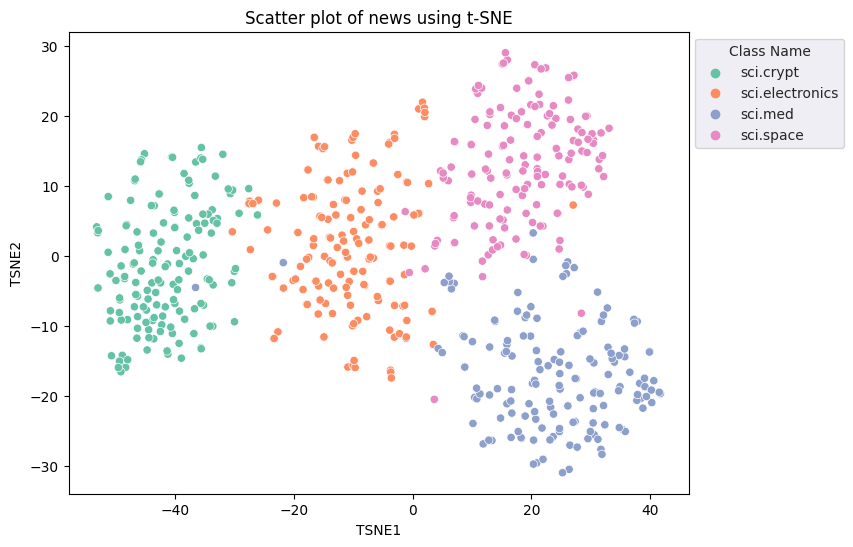

In [13]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

## Outlier detection

To determine which points are anomalous, you will determine which points are inliers and outliers. Start by finding the centroid, or location that represents the center of the cluster, and use the distance to determine the points that are outliers.

Start by getting the centroid of each category.

In [14]:
def get_centroids(df_tsne):
  # Get the centroid of each cluster
  centroids = df_tsne.groupby('Class Name').mean()
  return centroids

centroids = get_centroids(df_tsne)
centroids

,TSNE1,TSNE2
Class Name,,
sci.crypt,-41.689686,-1.321284
sci.electronics,-10.315932,1.664602
sci.med,23.834003,-16.932379
sci.space,17.985903,12.522058


In [15]:
def get_embedding_centroids(df):
  emb_centroids = dict()
  grouped = df.groupby('Class Name')
  for c in grouped.groups:
    sub_df = grouped.get_group(c)
    # Get the centroid value of dimension 768
    emb_centroids[c] = np.mean(sub_df['Embeddings'], axis=0)

  return emb_centroids

In [16]:
emb_c = get_embedding_centroids(df_train)

Plot each centroid you have found against the rest of the points.

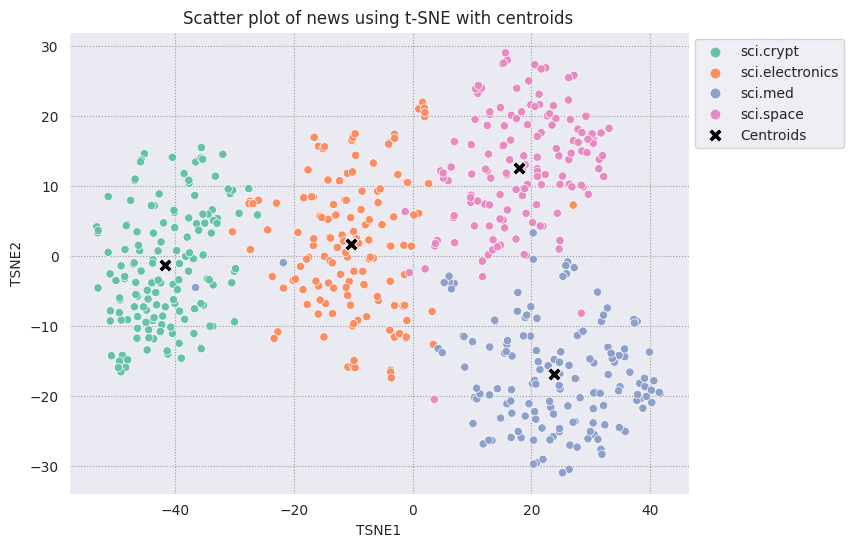

In [17]:
# Plot the centroids against the cluster
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE with centroids')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Choose a radius. Anything beyond this bound from the centroid of that category is considered an outlier.

In [18]:
def calculate_euclidean_distance(p1, p2):
  return np.sqrt(np.sum(np.square(p1 - p2)))

def detect_outlier(df, emb_centroids, radius):
  for idx, row in df.iterrows():
    class_name = row['Class Name'] # Get class name of row
    # Compare centroid distances
    dist = calculate_euclidean_distance(row['Embeddings'],
                                        emb_centroids[class_name])
    df.at[idx, 'Outlier'] = dist > radius

  return len(df[df['Outlier'] == True])

In [19]:
range_ = np.arange(0.3, 0.75, 0.02).round(decimals=2).tolist()
num_outliers = []
for i in range_:
  num_outliers.append(detect_outlier(df_train, emb_c, i))

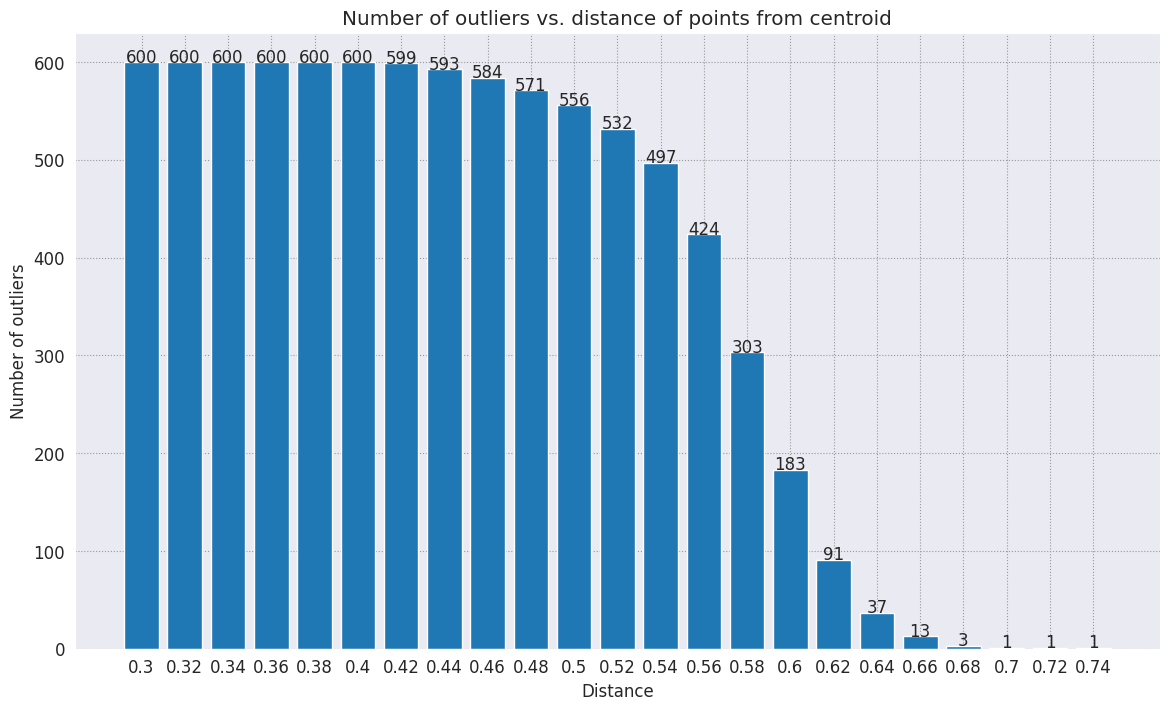

In [20]:
# Plot range_ and num_outliers
fig = plt.figure(figsize = (14, 8))
plt.rcParams.update({'font.size': 12})
plt.bar(list(map(str, range_)), num_outliers)
plt.title("Number of outliers vs. distance of points from centroid")
plt.xlabel("Distance")
plt.ylabel("Number of outliers")
for i in range(len(range_)):
  plt.text(i, num_outliers[i], num_outliers[i], ha = 'center')

plt.show()

Depending on how sensitive you want your anomaly detector to be, you can choose which radius you would like to use. For now, 0.62 is used, but you can change this value.

In [21]:
# View the points that are outliers
RADIUS = 0.62
detect_outlier(df_train, emb_c, RADIUS)
df_outliers = df_train[df_train['Outlier'] == True]
df_outliers.head()

,Text,Label,Class Name,Embeddings,Outlier
34,Privacy & Anonymity on the Internet FAQ \nSup...,11,sci.crypt,"[0.00901541, -0.050657988, -0.04197204, -0.038...",True
42,freely distributable public key cryptography ...,11,sci.crypt,"[0.03072634, -0.023314659, -0.094281256, -0.09...",True
59,Re: List of large integer arithmetic packages...,11,sci.crypt,"[-0.0055461614, 0.0061755483, -0.060710818, -0...",True
66,"Bob ""Putz"" Cain \nNntp-Posting-Host: next7.c...",11,sci.crypt,"[0.026052762, -0.053118147, -0.05200954, -0.07...",True
71,Re: disk safety measure?\nReply-To: \nOrganiz...,11,sci.crypt,"[0.039500915, -0.017621001, -0.061335266, -0.0...",True


In [22]:
# Use the index to map the outlier points back to the projected TSNE points
outliers_projected = df_tsne.loc[df_outliers['Outlier'].index]

Plot the outliers and denote them using a transparent red color.

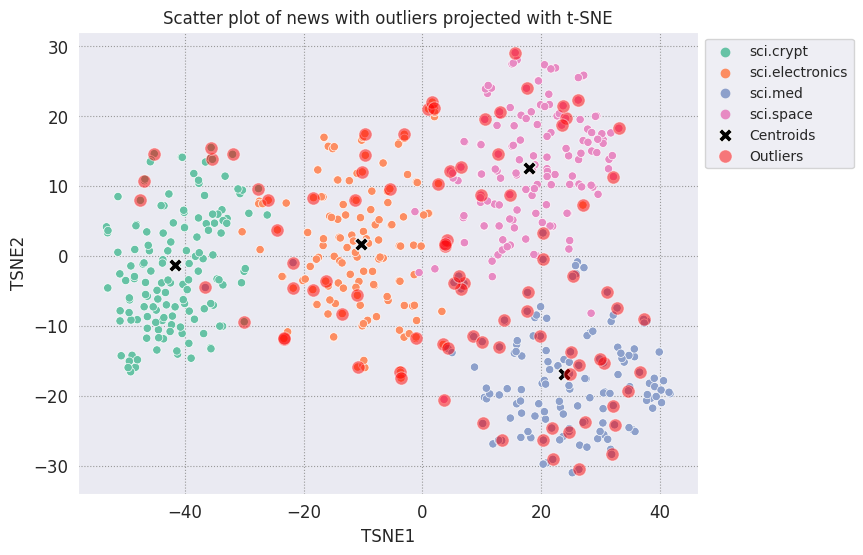

In [23]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
plt.rcParams.update({'font.size': 10})
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='Set2');
sns.scatterplot(data=centroids, x='TSNE1', y='TSNE2', color="black", marker='X', s=100, label='Centroids')
# Draw a red circle around the outliers
sns.scatterplot(data=outliers_projected, x='TSNE1', y='TSNE2', color='red', marker='o', alpha=0.5, s=90, label='Outliers')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news with outliers projected with t-SNE')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2');

Use the index values of the datafames to print a few examples of what outliers can look like in each category. Here, the first data point from each category is printed out. Explore other points in each category to see data that are deemed as outliers, or anomalies.

In [24]:
sci_crypt_outliers = df_outliers[df_outliers['Class Name'] == 'sci.crypt']
print(sci_crypt_outliers['Text'].iloc[0])

 Privacy & Anonymity on the Internet FAQ 
Supersedes: <net-privacy/>
Organization: TMP Enterprises
Lines: 1201
Expires: 21 May 1993 04:00:06 GMT
Reply-To: 
NNTP-Posting-Host: pad-thai.aktis.com
Summary: Notes on the use, history, and value of anonymous Usenet
 posting and email remailing services
X-Last-Updated: 1993/03/04

Archive-name: net-privacy/part3
Last-modified: 1993/3/3
Version: 2.1


NOTES on ANONYMITY on the INTERNET

Compiled by L. Detweiler <>.


<8.1> What are some known anonymous remailing and posting sites?
<8.2> What are the responsibilities associated with anonymity?
<8.3> How do I `kill' anonymous postings?
<8.4> What is the history behind anonymous posting servers?
<8.5> What is the value of anonymity?
<8.6> Should anonymous posting to all groups be allowed?
<8.7> What should system operators do with anonymous postings?
<8.8> What is going on with anon.penet.fi maintained by J. Helsingius?


* * *

_____
<8.1> What are some known anonymous remailing and posting site

In [25]:
sci_elec_outliers = df_outliers[df_outliers['Class Name'] == 'sci.electronics']
print(sci_elec_outliers['Text'].iloc[0])

 Re: Suggestions  on Audio relays ???
Organization: Malaspina College
Lines: 63

In article <>,   writes:
> In article <>   writes:
>>I built a little project using the radio shack 5vdc relays to switch
>>audio.  I got pretty bad 'clicks' when the thing switched.  I was doing
>>most of the common things one is supposed to do when using relays and
>>nothing seemed to get rid of the clicks.
>>
>>
>>My question is:
>>
>>	Is there a good relay/relay circuit that I can use for switching
>>audio, so that there will be *NO* noise of any kind on the audio lines.
>>
>>
>>I will appreciate any advice or references to advice.  Also, exact part
>>numbers/company names etc. for the relays will help!
> 
> Are you switching high level signals or low level signals like pre-amp
> out level signals?  Also, are the clicks you mentioning the big
> clack that happens when it switches or are you refering to contact
> bounce?  How are you driving the relays?  TTL gate output?  Switching
> transistor?  How ar

In [26]:
sci_med_outliers = df_outliers[df_outliers['Class Name'] == 'sci.med']
print(sci_med_outliers['Text'].iloc[0])

 Re: Krillean Photography
Organization: Stratus Computer, Inc.
Lines: 14
Distribution: world
NNTP-Posting-Host: coyoacan.sw.stratus.com

In article <>,   writes:
> I think that's the correct spelling..

The proper spelling is Kirlian. It was an effect discoverd by
S. Kirlian, a soviet film developer in 1939.

As I recall, the coronas visible are ascribed to static discharges
and chemical reactions between the organic material and the silver
halides in the films.

-- 
         Tarl Neustaedter       Stratus Computer
       	     Marlboro, Mass.
Disclaimer: My employer is not responsible for my opinions.



In [27]:
sci_space_outliers = df_outliers[df_outliers['Class Name'] == 'sci.space']
print(sci_space_outliers['Text'].iloc[0])

 White House outlines options for station, Russian cooperation
X-Added: Forwarded by Space Digest
Organization: [via International Space University]
Original-Sender: 
Distribution: sci
Lines: 71

------- Blind-Carbon-Copy

To: , White House outlines options for station, Russian cooperation
Date: Tue, 06 Apr 93 16:00:21 PDT
Richard Buenneke <>

4/06/93:  GIBBONS OUTLINES SPACE STATION REDESIGN GUIDANCE

NASA Headquarters, Washington, D.C.
April 6, 1993

RELEASE:  93-64

        Dr.  John H.  Gibbons, Director, Office of Science and Technology
Policy, outlined to the members-designate of the Advisory Committee on the
Redesign of the Space Station on April 3, three budget options as guidance
to the committee in their deliberations on the redesign of the space
station.

        A low option of $5 billion, a mid-range option of $7 billion and a
high option of $9 billion will be considered by the committee.  Each
option would cover the total expenditures for space station from fiscal
year 19

## Next steps

You've now created an anomaly detector using embeddings! Try using your own textual data to visualize them as embeddings, and choose some bound such that you can detect outliers. You can perform dimensionality reduction in order to complete the visualization step. Note that t-SNE is good at clustering inputs, but can take a longer time to converge or might get stuck at local minima. If you run into this issue, another technique you could consider are [principal components analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis).